# Installation and configuration of IBL packages

In [1]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 4.5 MB/s eta 0:00:0

In [2]:
# When running in jupyter set number of threads to 1
import os
os.environ.setdefault('ONE_HTTP_DL_THREADS', '1')

from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [3]:
# Suppress some future warnings
import warnings
warnings.simplefilter("ignore", FutureWarning)

# Change the load method depending on python version
from one.remote.aws import s3_download_file, get_s3_public
import pandas as pd
import sys
python_ver = sys.version_info

if python_ver >= (3, 10):
    from one.alf.path import add_uuid_string
else:
    from one.alf.files import add_uuid_string

s3, bucket = get_s3_public()

def load_aggregate(subject, dataset):
    if sys.version_info >= (3, 10):
        return one.load_aggregate('subjects', subject, dataset)
    else:
        files = one.list_aggregates('subjects', subject, dataset=dataset)
        files = files.iloc[0]
        src_path = str(add_uuid_string(files['rel_path'], files.name))
        dst_path = one.cache_dir.joinpath(files['rel_path'])
        local_file = s3_download_file(src_path, dst_path, s3=s3, bucket_name=bucket)
        return pd.read_parquet(local_file)

# Finding subjects with training data

In [8]:
import numpy as np

# Find all aggregate training datasets from IBL behaviour paper
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')

# Find the subject name from the info stored in the relative path
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# Loading trials data for a single subject

In [31]:
# Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[2]
subject_trials = load_aggregate(subject, '_ibl_subjectTrials.table.pqt')
session_trials = load_aggregate(subject, '_ibl_subjectSessions.table.pqt')

# Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

/usr/local/lib/python3.12/dist-packages/one/util.py:414: ALFWarning: No default revision for dataset aggregates/Subjects/churchlandlab/CSHL047/#2024-08-21#/_ibl_subjectTrials.table.pqt; using most recent
  warnings.warn(
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL047/#2024-08-21#/_ibl_subjectTrials.table.pqt: 100%|██████████| 6.15M/6.15M [00:00<00:00, 7.02MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL047/_ibl_subjectSessions.table.pqt: 100%|██████████| 7.99k/7.99k [00:00<00:00, 46.6kB/s]


The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.ls81qq9ihg4x) for more information about this dataset.

We can find the number of sessions collected, or the number of times the subject was run under a specific task protocol

In [35]:
# Spike verisi olan oturumları bul
sessions_with_spikes = one.search(datasets='spikes.times')
print(f"Spike verisi olan toplam oturum sayısı: {len(sessions_with_spikes)}")

if len(sessions_with_spikes) > 0:
    print("İlk 5 oturum:")
    for i, eid in enumerate(sessions_with_spikes[:5]):
        print(f"{i+1}. {eid}")
else:
    print("Spike verisi bulunamadı!")

Spike verisi olan toplam oturum sayısı: 0
Spike verisi bulunamadı!


In [32]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')

# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL047 has 55 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.2.5      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5     5
_iblrig_tasks_ephysChoiceWorld6.2.5        5
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_biasedChoiceWorld6.3.1       3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
_iblrig_tasks_trainingChoiceWorld6.2.0     1
Name: count, dtype: int64


In [33]:
# İlk oturumu seç
first_session = subject_trials.index.unique()[9]
print(f"Seçilen oturum: {first_session}")

# Bu oturum ID'sini eid olarak kullan
eid = first_session

Seçilen oturum: 5aca9703-ce7d-4b92-96a8-15cfd0bfb373


In [34]:
# Mevcut veri setlerini listele
datasets = one.list_datasets(eid)

# Spikes ile ilgili veri setlerini filtrele
spike_datasets = [d for d in datasets if 'spikes' in d]
print(f"\n{len(spike_datasets)} adet spikes veri seti bulundu:")
for d in spike_datasets:
    print(f"  {d}")


0 adet spikes veri seti bulundu:


We can get the trials data for an individual session of choice, here a the first session using the biasedChoiceWorld protocol

In [36]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

Number of trials for session 6f736bcb-ce12-4b02-abca-ca651ded95a8: 762
Performance easy for session 6f736bcb-ce12-4b02-abca-ca651ded95a8: 0.9612903225806452


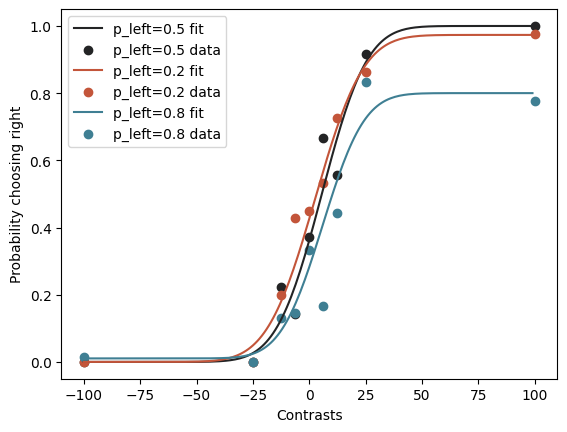

In [37]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')

## Combining training criteria

Another [dataset](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.18vu2zskyq0r) is available that contains information about the session at which the subject reached certain training criteria in the IBL training pipeline. More information can be found about the training pipeline in the study [A standardized and reproducible method to measure decision-making in mice](https://doi.org/10.1101/2020.01.17.909838).

We can download this dataset in the following way

In [38]:
subject_training = load_aggregate(subject, '_ibl_subjectTraining.table.pqt')

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL047/#2024-08-21#/_ibl_subjectTraining.table.pqt: 100%|██████████| 3.14k/3.14k [00:00<00:00, 17.1kB/s]


We can combine this with our subject trials table to see how the subject progressed

In [39]:
subject_trials = (subject_trials
          .join(subject_training.set_index('session'))
          .sort_values(by=['session_start_time', 'intervals_0']))
subject_trials['training_status'] = subject_trials.training_status.fillna(method='ffill')

Our subject trials table now has a new column that indicates the training criteria of the mouse at each session. We can use this information to make a plot of how the performance of the mouse improved across training days.

We will need to compute the performance per session and add this column to our dataframe and also add in a column for training day.

In [40]:
sessions = subject_trials.index.unique()
for n_sess, sess in enumerate(sessions):
  trials = subject_trials[subject_trials.index == sess]
  perf_easy = compute_performance_easy(trials)
  subject_trials.loc[subject_trials.index == sess, 'performance_easy'] = perf_easy
  subject_trials.loc[subject_trials.index == sess, 'training_day'] = n_sess

Note since we already ordered by session_start_time above our table was already sorted. Here we have simply assigned each training session to a training day but there are some cases where multiple training sessions were run on the same day so this may be something you want to account for in your analysis.

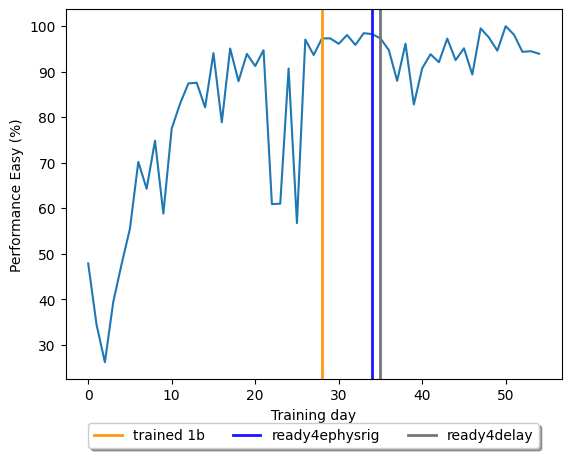

In [41]:
import matplotlib.pyplot as plt
from ibllib.pipes.training_status import TRAINING_STATUS
fig, ax = plt.subplots(1, 1)
ax.plot(subject_trials['training_day'], subject_trials['performance_easy'] * 100)
ax.set_xlabel("Training day")
ax.set_ylabel("Performance Easy (%)")
status = subject_trials.drop_duplicates(subset='training_status', keep='first')
for _, st in status.iterrows():
    if st['training_status'] in ['untrainable', 'unbiasable']:
        continue
    if TRAINING_STATUS[st['training_status']][0] <= 0:
        continue
    ax.axvline(st['training_day'], linewidth=2,
               color=np.array(TRAINING_STATUS[st['training_status']][1]) / 255, label=st['training_status'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   fancybox=True, shadow=True, ncol=5)

# Combining data across multiple subjects

We can loop over all the subjects available to get a large dataframe that contains the data for all the subjects. Here is an example of how this can be done


In [43]:
import pandas as pd

all_trials = []

# Download two tables, subject trials table and subject training table and combine
for i, subject in enumerate(subjects):
  if np.mod(i, 50) == 0:
    print(f'{i}/{len(subjects)}')

  # Load trials table for subject
  subject_trials = load_aggregate(subject, '_ibl_subjectTrials.table.pqt')

  # Load sessions table for subject
  session_trials = load_aggregate(subject, '_ibl_subjectSessions.table.pqt')

  # Load training status for subject
  subject_training = load_aggregate(subject, '_ibl_subjectTraining.table.pqt')

  # Combine the two tables
  subject_trials = (subject_trials
            .set_index('session')
            .join(subject_training.set_index('session'))
            .sort_values(by=['session_start_time', 'intervals_0']))
  subject_trials['training_status'] = subject_trials.training_status.fillna(method='ffill')

  # Join sessions table for number, task_protocol, etc.
  if 'task_protocol' in subject_trials:
      subject_trials = subject_trials.drop('task_protocol', axis=1)
  subject_trials = subject_trials.join(session_trials.drop('date', axis=1))

  # Sort the trials by session start time and trial number
  subject_trials = subject_trials.sort_values(by=['session_start_time', 'intervals_0'])


  # add in extra columns for performance easy and training day
  sessions = subject_trials.index.unique()
  for n_sess, sess in enumerate(sessions):
    trials = subject_trials[subject_trials.index == sess]
    perf_easy = compute_performance_easy(trials)
    subject_trials.loc[subject_trials.index == sess, 'performance_easy'] = perf_easy
    subject_trials.loc[subject_trials.index == sess, 'training_day'] = n_sess


  all_trials.append(subject_trials)

all_trials = pd.concat(all_trials)

0/140


/usr/local/lib/python3.12/dist-packages/one/util.py:414: ALFWarning: No default revision for dataset aggregates/Subjects/churchlandlab/CSHL045/#2024-04-10#/_ibl_subjectTrials.table.pqt; using most recent
  warnings.warn(


KeyboardInterrupt: 

Once we have this large training table aggregated across all subjects we can manipulate this table to view different properties. For example we can see how the pyshcometric curves varies across the different training stages across all subjects

In [44]:
import seaborn as sns
# plot psychometric curves for the whole dataframe
all_trials = all_trials.reset_index()
all_trials['signed_contrast'] = np.nan
i = np.isnan(all_trials['contrastRight'])
all_trials.loc[i , 'signed_contrast'] = all_trials.loc[i, 'contrastLeft']
all_trials.loc[~i, 'signed_contrast'] = - all_trials.loc[~i, 'contrastRight']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
sns.lineplot(data=all_trials.loc[all_trials['probabilityLeft'] == 0.5], x='signed_contrast', y='choice', hue='training_status', ax=ax)

AttributeError: 'list' object has no attribute 'reset_index'

Or we can look how the performance on easy trial progresses over training days across labs

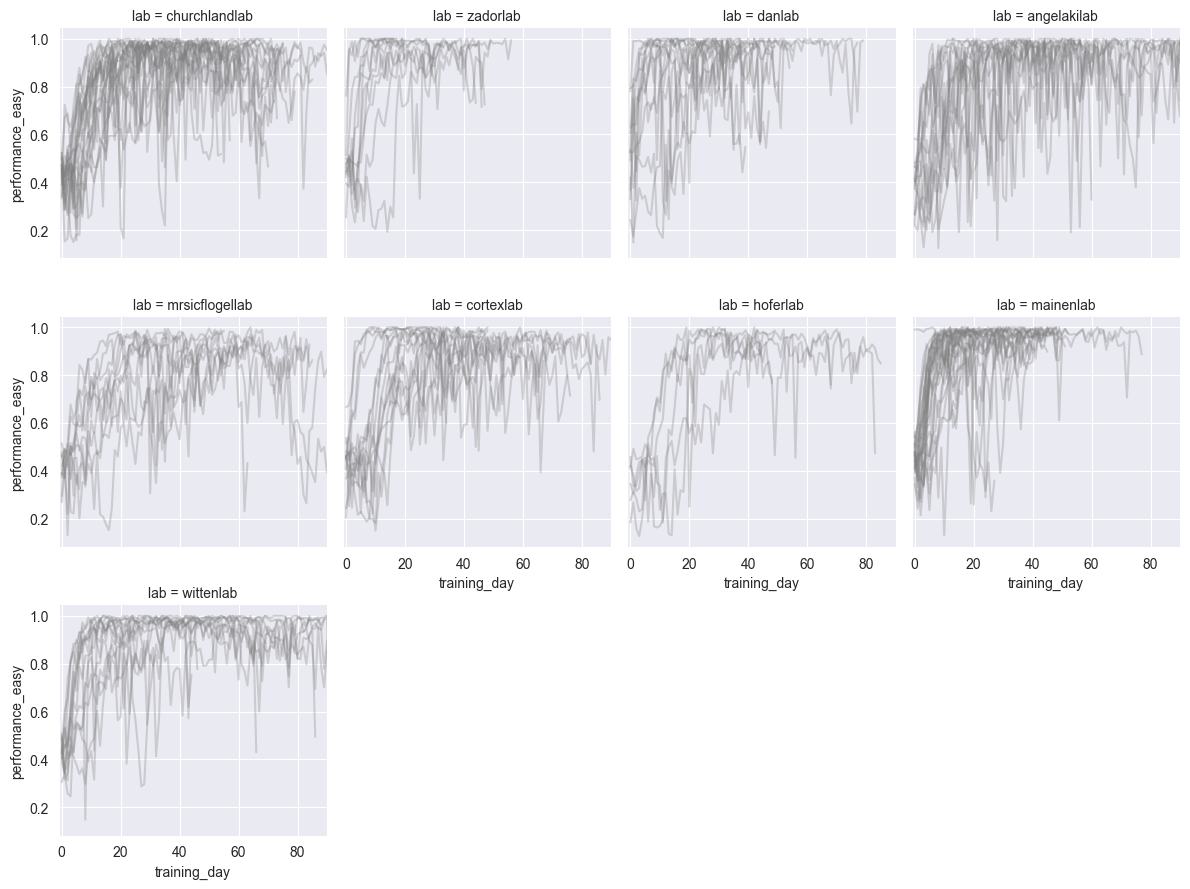

In [ ]:
# Remove duplicate rows that we don't need for the plots
fig = sns.FacetGrid(all_trials.drop_duplicates('session'),
                    col="lab", col_wrap=4,
                    sharex=True, sharey=True, aspect=1, hue="subject", xlim=[-1, 90])
fig.map(sns.lineplot, "training_day",
        "performance_easy", color='gray', alpha=0.3)

# Additional resources

Documentation

- [ONE documentation](https://int-brain-lab.github.io/iblenv/notebooks_external/one_quickstart.html#)
- [Getting started with ONE](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7)
- [Loading trials data](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_trials_data.html)


Where can I find help?
- Issues with the data? Post an issue here: https://neurostars.org/ with the tag `ibl`
- Alternatively post an issue here: https://github.com/int-brain-lab/iblenv/issues
- General questions about the datasets or publications? Email: info@internationalbrainlab.org




> *All data are made available under the CC BY 4.0 license.*

In [45]:
# Spike verisi olan oturumları bul
sessions_with_spikes = one.search(datasets='spikes.times')
print(f"Spike verisi olan toplam oturum sayısı: {len(sessions_with_spikes)}")

if len(sessions_with_spikes) > 0:
    print("İlk 5 oturum:")
    for i, eid in enumerate(sessions_with_spikes[:5]):
        print(f"{i+1}. {eid}")
else:
    print("Spike verisi bulunamadı!")

Spike verisi olan toplam oturum sayısı: 0
Spike verisi bulunamadı!


In [46]:
# Doğrudan tag ile elektrofizyoloji verilerini arayın
datasets = one.alyx.rest('datasets', 'list',
                         tag='2022_Q2_IBL_et_al_BWM',
                         dataset_type='spikes.times')

print(f"Bulunan spike veri seti sayısı: {len(datasets)}")

if len(datasets) > 0:
    # İlk veri setinden oturum ID'sini al
    eid = datasets[0]['session']
    print(f"Oturum ID: {eid}")

    # Bu oturumda hangi collection'lar var?
    all_datasets = one.list_datasets(eid)
    spike_files = [d for d in all_datasets if 'spikes.times' in d]
    print(f"Spike dosyaları: {spike_files}")
else:
    print("Bu yöntemle de bulunamadı, başka bir tag deneyelim...")

Bulunan spike veri seti sayısı: 0
Bu yöntemle de bulunamadı, başka bir tag deneyelim...


In [47]:
# Mevcut tüm tagları listele
tags = one.alyx.rest('tags', 'list')
print("Mevcut tag'ler:")
for tag in tags:
    if 'IBL' in tag.get('name', ''):
        print(f"  {tag['name']}")

Mevcut tag'ler:
  2021_Q1_IBL_et_al_Behaviour
  2022_Q2_IBL_et_al_RepeatedSite
  2022_Q3_IBL_et_al_DAWG
  2022_Q4_IBL_et_al_BWM
  2023_Q4_IBL_et_al_BWM_2
  2023_Q4_IBL_et_al_BWM_passive
  2024_Q2_IBL_et_al_BWM_iblsort
  2024_Q2_IBL_et_al_RepeatedSite
  2025_Q1_IBL_et_al_BWM_wheel_patch
  2025_Q3_IBL_et_al_BWM


In [48]:
# Tüm oturumları al (ilk 100 tanesini)
all_sessions = one.search()[:100]
print(f"Taranan oturum sayısı: {len(all_sessions)}")

sessions_with_spikes = []
for i, eid in enumerate(all_sessions):
    try:
        datasets = one.list_datasets(eid)
        if any('spikes.times' in d for d in datasets):
            sessions_with_spikes.append(eid)
            print(f"✓ {i+1}/{len(all_sessions)}: {eid} - Spike verisi VAR")
            if len(sessions_with_spikes) >= 5:  # İlk 5'ini bulunca dur
                break
    except:
        pass

print(f"\nToplam {len(sessions_with_spikes)} oturum bulundu")

Taranan oturum sayısı: 100
✓ 32/100: ebce500b-c530-47de-8cb1-963c552703ea - Spike verisi VAR
✓ 88/100: a7eba2cf-427f-4df9-879b-e53e962eae18 - Spike verisi VAR
✓ 91/100: 5ae68c54-2897-4d3a-8120-426150704385 - Spike verisi VAR
✓ 92/100: 3a3ea015-b5f4-4e8b-b189-9364d1fc7435 - Spike verisi VAR

Toplam 4 oturum bulundu


In [49]:
# Bulunan oturumlardan birini seç
sessions_with_spikes = [
    'ebce500b-c530-47de-8cb1-963c552703ea',
    'a7eba2cf-427f-4df9-879b-e53e962eae18',
    '5ae68c54-2897-4d3a-8120-426150704385',
    '3a3ea015-b5f4-4e8b-b189-9364d1fc7435'
]

# İlk oturumu seç
eid = sessions_with_spikes[0]
print(f"Seçilen oturum: {eid}")

# Bu oturumda hangi spike dosyaları var?
datasets = one.list_datasets(eid)
spike_files = [d for d in datasets if 'spikes.times' in d]
print(f"\nMevcut spike dosyaları:")
for f in spike_files:
    print(f"  {f}")

# Collection'ı çıkar (örn: 'alf/probe00')
if spike_files:
    collection = spike_files[0].replace('/spikes.times.npy', '')
    print(f"\nCollection: {collection}")

    # Spikes.times verilerini yükle
    spikes_times = one.load_dataset(eid, 'spikes.times', collection=collection)

    print(f"\n✓ BAŞARILI! Veriler yüklendi:")
    print(f"Toplam spike sayısı: {len(spikes_times):,}")
    print(f"\nİlk 10 spike zamanı (saniye):")
    print(spikes_times[:10])
    print(f"\nİstatistikler:")
    print(f"  En erken spike: {spikes_times.min():.2f} saniye")
    print(f"  En geç spike: {spikes_times.max():.2f} saniye")
    print(f"  Toplam kayıt süresi: {(spikes_times.max() - spikes_times.min())/60:.2f} dakika")

Seçilen oturum: ebce500b-c530-47de-8cb1-963c552703ea

Mevcut spike dosyaları:
  alf/probe00/pykilosort/#2024-03-22#/spikes.times.npy
  alf/probe00/pykilosort/#2024-05-06#/spikes.times.npy
  alf/probe00/pykilosort/spikes.times.npy

Collection: alf/probe00/pykilosort/#2024-03-22#


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/MFD_09/2023-10-19/001/alf/probe00/pykilosort/#2024-03-22#/spikes.times.npy: 100%|██████████| 665M/665M [00:08<00:00, 82.5MB/s]



✓ BAŞARILI! Veriler yüklendi:
Toplam spike sayısı: 83,088,509

İlk 10 spike zamanı (saniye):
[0.00693403 0.0075007  0.00926736 0.00933403 0.00976736 0.0100007
 0.0111007  0.01123403 0.01193403 0.01196736]

İstatistikler:
  En erken spike: 0.01 saniye
  En geç spike: 7200.22 saniye
  Toplam kayıt süresi: 120.00 dakika
